## Libraries

In [172]:
#Lib import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from scipy.optimize import minimize
import seaborn as sns
from scipy.optimize import differential_evolution

In [3]:
# Additional instalations
#!pip install seaborn
#!pip install yfinance

Instructions

Compute daily returns if not already done so

Perform a short exploratory analysis of your data. Discuss the expected values, covariances
and auto-covariances of your returns, How these characteristics change in time? 

## Data preprocessing

In [81]:
def download_stock_data(stock_files, output_dir):
    """
    Download historical stock data using yfinance and save to CSV files with consistent date formatting.
    
    Parameters:
    stock_files (dict): Dictionary with stock tickers as keys and output filenames as values
    output_dir (str): Directory to save the CSV files
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Calculate date range (for the assignment period)
    start_date = '2021-01-01'  # January 1, 2021
    end_date = '2024-10-26'    # October 26, 2024
    
    # Download data for each ticker
    for ticker, filename in stock_files.items():
        try:
            # Get stock data
            stock = yf.Ticker(ticker)
            df = stock.history(start=start_date, end=end_date)
            
            # Convert index to date format without time component
            df.index = df.index.date
            
            # Name the index column
            df.index.name = 'Date'
            
            # Save to CSV
            output_path = os.path.join(output_dir, filename)
            df.to_csv(output_path)
            print(f"Successfully downloaded data for {ticker} to {filename}")
            
        except Exception as e:
            print(f"Error downloading data for {ticker}: {str(e)}")
            
# When reading the CSV files back, use:
# df = pd.read_csv(file_path, parse_dates=True, index_col='Date')

In [82]:
# Define the directory containing your stock data
data_dir = r"D:\Projects\ds2-hw\Projekt -AnalyzaInvestic\stock_data" #changable


stock_files = {
    'SPLP': 'Steel Partners Holdings L.P. Stock Price History.csv',
    'TEAM': 'Atlassian Stock Price History.csv',
    'BIDU': 'Baidu Stock Price History.csv',
    'ADBE': 'Adobe Stock Price History.csv',
    'MDLZ': 'Mondelez Stock Price History.csv',
    'AMD': 'AMD Stock Price History.csv',
    'VRSN': 'Verisign Stock Price History.csv',
    'PAYX': 'Paychex Stock Price History.csv',
}

# Dir for risk free asset
risk_free_file = r'D:\Projects\ds2-hw\Projekt -AnalyzaInvestic\USYields2024.csv'

In [83]:
# Downloading data
stock_data = download_stock_data(stock_files,'stock_data')

Successfully downloaded data for SPLP to Steel Partners Holdings L.P. Stock Price History.csv
Successfully downloaded data for TEAM to Atlassian Stock Price History.csv
Successfully downloaded data for BIDU to Baidu Stock Price History.csv
Successfully downloaded data for ADBE to Adobe Stock Price History.csv
Successfully downloaded data for MDLZ to Mondelez Stock Price History.csv
Successfully downloaded data for AMD to AMD Stock Price History.csv
Successfully downloaded data for VRSN to Verisign Stock Price History.csv
Successfully downloaded data for PAYX to Paychex Stock Price History.csv


In [84]:
# Function to calculate daily returns
def calculate_daily_returns(data):
    """
    Calculates daily returns as the logarithm of the ratio of Price to Open prices.
    """
    data['Daily_Return'] = np.log(data['Close'] / data['Open']) # log(Close/Open)
    return data[['Date', 'Daily_Return']]

Loading data into one table and filter 1 Yr risk free rate with the Date


In [85]:
# Load and process stock data

daily_returns = {} # Table with all daily returns in one place
all_data = {}  # Dictionary with ticker as key

for ticker, file_name in stock_files.items():
    file_path = os.path.join(data_dir, file_name)
    print(f"Processing data for {ticker} from {file_path}...")
    data = pd.read_csv(file_path, parse_dates=['Date'])
    data['Ticker'] = ticker  # Add a column for the ticker
    daily_returns[ticker] = calculate_daily_returns(data).set_index('Date')
    all_data[ticker] = data  # Store the full data in the dictionary

# Combine daily returns into a single DataFrame
combined_returns = pd.concat(
    [df['Daily_Return'].rename(ticker) for ticker, df in daily_returns.items()],
    axis=1
)

Processing data for SPLP from D:\Projects\ds2-hw\Projekt -AnalyzaInvestic\stock_data\Steel Partners Holdings L.P. Stock Price History.csv...
Processing data for TEAM from D:\Projects\ds2-hw\Projekt -AnalyzaInvestic\stock_data\Atlassian Stock Price History.csv...
Processing data for BIDU from D:\Projects\ds2-hw\Projekt -AnalyzaInvestic\stock_data\Baidu Stock Price History.csv...
Processing data for ADBE from D:\Projects\ds2-hw\Projekt -AnalyzaInvestic\stock_data\Adobe Stock Price History.csv...
Processing data for MDLZ from D:\Projects\ds2-hw\Projekt -AnalyzaInvestic\stock_data\Mondelez Stock Price History.csv...
Processing data for AMD from D:\Projects\ds2-hw\Projekt -AnalyzaInvestic\stock_data\AMD Stock Price History.csv...
Processing data for VRSN from D:\Projects\ds2-hw\Projekt -AnalyzaInvestic\stock_data\Verisign Stock Price History.csv...
Processing data for PAYX from D:\Projects\ds2-hw\Projekt -AnalyzaInvestic\stock_data\Paychex Stock Price History.csv...


In [86]:
import pandas as pd

# Preprocessing of risk_free_file
risk_free_rate = pd.read_csv(risk_free_file)

# Remove leading/trailing spaces from column names
risk_free_rate.columns = risk_free_rate.columns.str.strip()

# Convert Date column to datetime format with dayfirst=True
risk_free_rate['Date'] = pd.to_datetime(risk_free_rate['Date'], dayfirst=True, errors='coerce')

# Ensure the '1 Mo' column is numeric and handle missing values
risk_free_rate['1 Mo'] = pd.to_numeric(risk_free_rate['1 Mo'], errors='coerce')

# Check if 'Date' column exists and proceed
if 'Date' in risk_free_rate.columns:
    # Filter columns
    risk_free_rate = risk_free_rate[['Date', '1 Mo']].dropna()

    # Filter date range
    mask = (risk_free_rate['Date'] >= '2021-01-01') & (risk_free_rate['Date'] <= '2024-10-25')
    risk_free_rate = risk_free_rate.loc[mask]

    # Convert the annualized rate into a daily rate (assuming 252 trading days in a year)
    risk_free_rate['Daily_Risk_Free_Rate'] = np.log(1 + risk_free_rate['1 Mo'] / 100)  / 252

    # Set the 'Date' column as the index for alignment with stock data
    risk_free_rate.set_index('Date', inplace=True)

    print("\nRisk-Free Rate Data (Head):")
    print(risk_free_rate.head())
    print(risk_free_rate.tail())
    print("\nDate range in the data:")
    print(f"Start date: {risk_free_rate.index.min()}")
    print(f"End date: {risk_free_rate.index.max()}")

    # Save the processed risk-free rate for later use
    risk_free_rate.to_csv('processed_risk_free_rate.csv')
    print("Risk-free rate processing complete. File saved as 'processed_risk_free_rate.csv'.")
else:
    print("The 'Date' column is missing or misnamed.")



Risk-Free Rate Data (Head):
            1 Mo  Daily_Risk_Free_Rate
Date                                  
2021-01-04  0.09              0.000004
2021-01-05  0.08              0.000003
2021-01-06  0.09              0.000004
2021-01-07  0.09              0.000004
2021-01-08  0.08              0.000003
            1 Mo  Daily_Risk_Free_Rate
Date                                  
2024-10-21  4.92              0.000191
2024-10-22  4.89              0.000189
2024-10-23  4.88              0.000189
2024-10-24  4.87              0.000189
2024-10-25  4.89              0.000189

Date range in the data:
Start date: 2021-01-04 00:00:00
End date: 2024-10-25 00:00:00
Risk-free rate processing complete. File saved as 'processed_risk_free_rate.csv'.


In [87]:
# Save processed data for further analysis
#combined_returns.to_csv('daily_returns.csv')
#risk_free_rate.to_csv('risk_free_rate.csv')

#("Data processing complete. Files saved as 'daily_returns.csv' and 'risk_free_rate.csv'.")

In [88]:
def compare_and_clean_dates_with_ffill(combined_returns, risk_free_rate):
    """
    Compare and clean dates between two dataframes, removing dates missing in combined_returns
    but forward-filling missing dates in risk_free_rate.
    
    Parameters:
    combined_returns (pd.DataFrame): DataFrame with potential timezone-aware dates.
    risk_free_rate (pd.DataFrame): DataFrame with datetime index.
    
    Returns:
    tuple: (missing_dates, cleaned_combined_returns, cleaned_risk_free_rate)
    """
    # Convert combined returns dates - handle timezone-aware dates
    combined_dates = combined_returns.index.tz_localize(None)  # Remove timezone first
    combined_dates = pd.to_datetime(combined_dates).date  # Then convert to date
    
    # Convert risk-free dates
    risk_free_dates = pd.to_datetime(risk_free_rate.index).date
    
    # Find missing dates
    combined_dates_set = set(combined_dates)
    risk_free_dates_set = set(risk_free_dates)
    missing_dates = sorted(combined_dates_set - risk_free_dates_set)  # Missing in risk-free
    missing_in_combined = sorted(risk_free_dates_set - combined_dates_set)  # Missing in combined
    
    # Create cleaned DataFrames
    cleaned_combined_returns = combined_returns.copy()
    cleaned_combined_returns.index = combined_dates  # Ensure date index is without time
    
    # Forward fill missing risk-free rates
    cleaned_risk_free_rate = risk_free_rate.copy()
    cleaned_risk_free_rate.index = risk_free_dates
    cleaned_risk_free_rate = cleaned_risk_free_rate.reindex(cleaned_combined_returns.index).ffill()
    
    # Return missing dates and cleaned dataframes
    return missing_dates, cleaned_combined_returns, cleaned_risk_free_rate



In [89]:
# Call the updated function
missing_dates, clean_returns, clean_risk_free = compare_and_clean_dates_with_ffill(combined_returns, risk_free_rate)

# Print missing dates in the risk-free rate (if any)
print("Missing Dates in Risk-Free Rate Data (before forward fill):")
for date in missing_dates:
    print(date)

# Print sample of cleaned data
print("\nSample of Cleaned Combined Returns Dates:")
print(clean_returns.index[:5])
print("\nSample of Cleaned Risk-Free Dates:")
print(clean_risk_free.index[:5])

Missing Dates in Risk-Free Rate Data (before forward fill):
2021-10-11
2021-11-11
2022-10-10
2022-11-11
2023-10-09
2024-10-14

Sample of Cleaned Combined Returns Dates:
Index([2021-01-04, 2021-01-05, 2021-01-06, 2021-01-07, 2021-01-08], dtype='object')

Sample of Cleaned Risk-Free Dates:
Index([2021-01-04, 2021-01-05, 2021-01-06, 2021-01-07, 2021-01-08], dtype='object')


In [90]:
# Ensure missing_dates are datetime64[ns]
missing_dates = pd.to_datetime(missing_dates)

# Now apply to combined_returns
combined_returns_cleaned = combined_returns[~combined_returns.index.isin(missing_dates)]
risk_free_rate_cleaned = clean_risk_free
# Similarly for risk_free_rate
# missing_dates2 = pd.to_datetime(missing_dates2)
# risk_free_rate_cleaned = risk_free_rate[~risk_free_rate.index.isin(missing_dates2)]

## Exploratory Analysis

In [91]:
# Summary of Risk-Free Rate and combined Results
print("\nDaily Returns Summary:")
print(combined_returns_cleaned.describe())

print("\nRisk-Free Rate Summary:")
print(risk_free_rate_cleaned.describe())


Daily Returns Summary:
             SPLP        TEAM        BIDU        ADBE        MDLZ         AMD  \
count  954.000000  954.000000  954.000000  954.000000  954.000000  954.000000   
mean     0.002165    0.000912   -0.000224   -0.000124   -0.000196   -0.000369   
std      0.020058    0.029616    0.024559    0.017443    0.010242    0.027233   
min     -0.091406   -0.106688   -0.133468   -0.076126   -0.070633   -0.108413   
25%     -0.005034   -0.015460   -0.013933   -0.009985   -0.005948   -0.015317   
50%      0.000000    0.002303   -0.000975    0.000600   -0.000064   -0.000308   
75%      0.007842    0.018223    0.011899    0.010854    0.005845    0.015141   
max      0.127833    0.109976    0.179819    0.102605    0.037771    0.109074   

             VRSN        PAYX  
count  954.000000  954.000000  
mean    -0.000064    0.000188  
std      0.012823    0.012543  
min     -0.050470   -0.062812  
25%     -0.007423   -0.007064  
50%      0.000118    0.000297  
75%      0.007504    0

In [92]:
print("\n First 5 rows")
print(combined_returns_cleaned.head())
print("\n Last 5 rows")
print(risk_free_rate_cleaned.tail())


 First 5 rows
                SPLP      TEAM      BIDU      ADBE      MDLZ       AMD  \
Date                                                                     
2021-01-04 -0.049940 -0.012617 -0.012422 -0.030358 -0.009793  0.002061   
2021-01-05  0.005731  0.010377  0.002667 -0.000391  0.001553  0.007248   
2021-01-06  0.023289 -0.019586 -0.042286 -0.016568 -0.002072 -0.014180   
2021-01-07 -0.028560  0.023191  0.000866  0.014209  0.000693  0.041080   
2021-01-08  0.028560 -0.002206  0.056466  0.010569  0.014192 -0.014694   

                VRSN      PAYX  
Date                            
2021-01-04 -0.015517 -0.031053  
2021-01-05 -0.025389 -0.004655  
2021-01-06 -0.020735  0.012808  
2021-01-07 -0.001998  0.005917  
2021-01-08  0.007487  0.005995  

 Last 5 rows
            1 Mo  Daily_Risk_Free_Rate
2024-10-21  4.92              0.000191
2024-10-22  4.89              0.000189
2024-10-23  4.88              0.000189
2024-10-24  4.87              0.000189
2024-10-25  4.89          

In [93]:
# Exploratory analysis

print("Performing exploratory analysis...")
mean_returns = combined_returns_cleaned.mean()
cov_matrix = combined_returns_cleaned.cov()
auto_cov = combined_returns_cleaned.apply(lambda col: col.autocorr())

print("\nExpected Returns (Mean):")
print(mean_returns)
print("\nCovariance Matrix:")
print(cov_matrix)
print("\nAuto-covariances (Autocorrelations):")
print(auto_cov)

Performing exploratory analysis...

Expected Returns (Mean):
SPLP    0.002165
TEAM    0.000912
BIDU   -0.000224
ADBE   -0.000124
MDLZ   -0.000196
AMD    -0.000369
VRSN   -0.000064
PAYX    0.000188
dtype: float64

Covariance Matrix:
          SPLP      TEAM      BIDU      ADBE      MDLZ       AMD      VRSN  \
SPLP  0.000402  0.000049  0.000040  0.000040  0.000002  0.000060  0.000023   
TEAM  0.000049  0.000877  0.000268  0.000293  0.000033  0.000390  0.000168   
BIDU  0.000040  0.000268  0.000603  0.000153  0.000031  0.000248  0.000076   
ADBE  0.000040  0.000293  0.000153  0.000304  0.000036  0.000260  0.000123   
MDLZ  0.000002  0.000033  0.000031  0.000036  0.000105  0.000024  0.000046   
AMD   0.000060  0.000390  0.000248  0.000260  0.000024  0.000742  0.000127   
VRSN  0.000023  0.000168  0.000076  0.000123  0.000046  0.000127  0.000164   
PAYX  0.000034  0.000126  0.000073  0.000092  0.000050  0.000103  0.000082   

          PAYX  
SPLP  0.000034  
TEAM  0.000126  
BIDU  0.000073

#TBD
The expected returns show the average daily log returns for the assets. GOOGL and AVGO exhibit positive expected returns, indicating slight daily growth, while other assets, such as LULU and AMGN, have negative expected returns, suggesting slight daily losses. The covariance matrix highlights relationships in return variability between assets. For example, GOOGL and AVGO have a relatively high covariance (0.000141), suggesting they tend to move together. On the other hand, the autocovariances (or autocorrelations) suggest the persistence of daily returns over time; for instance, GOOGL and AMGN show slight positive autocorrelations, while TXN and DLTR exhibit notable negative autocorrelations.

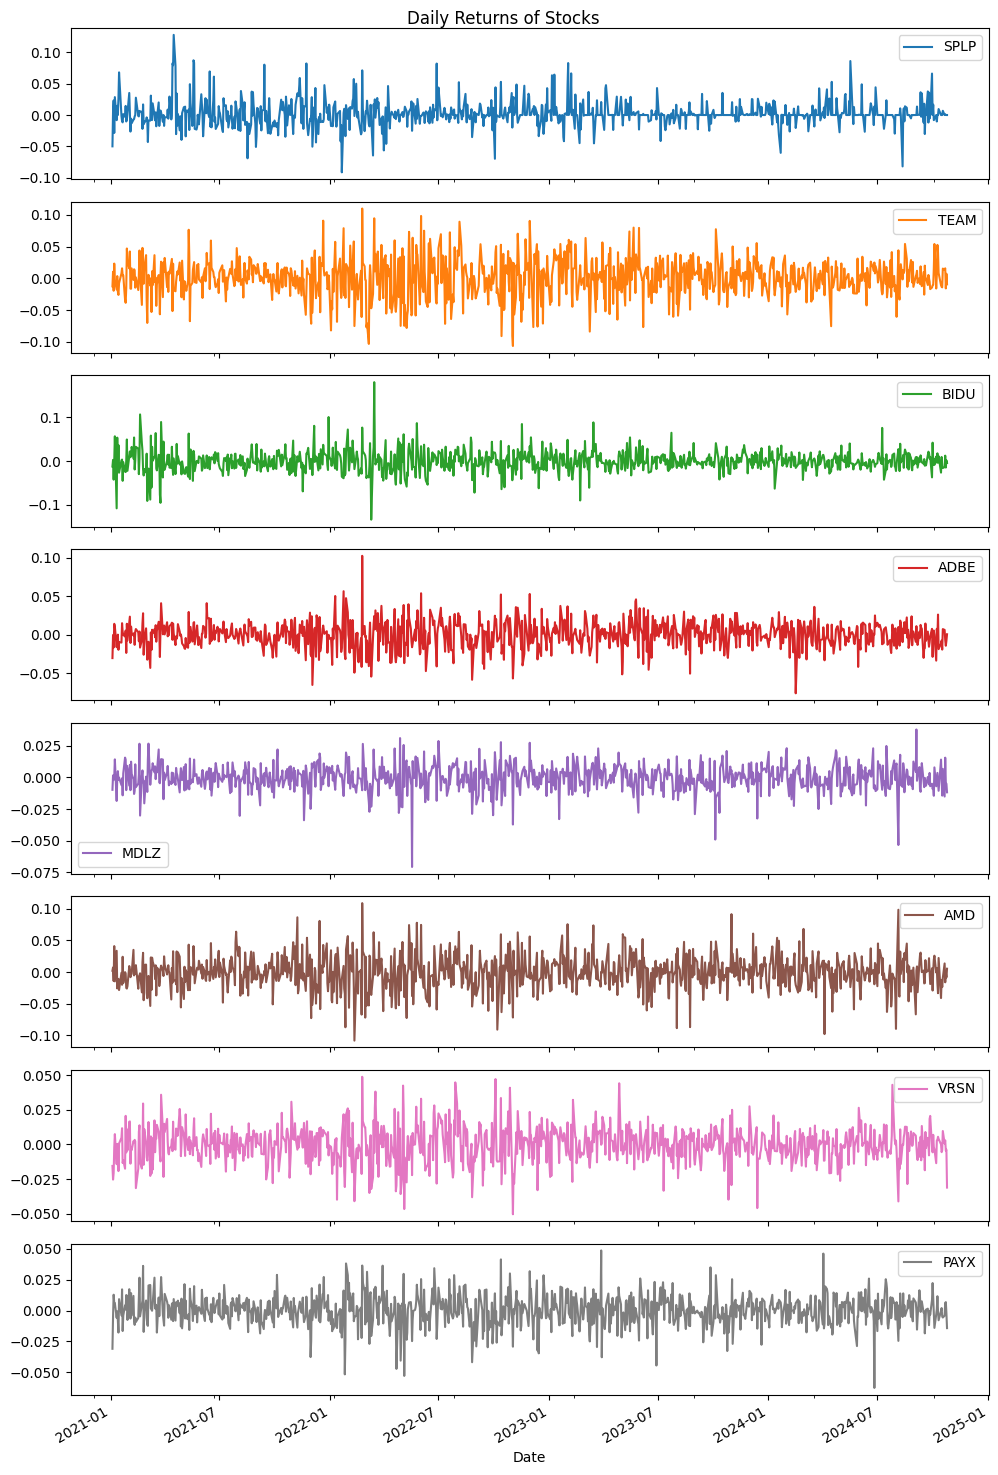

In [94]:
# Plotting daily returns
combined_returns_cleaned.plot(subplots=True, figsize=(10, 15), title='Daily Returns of Stocks')
plt.tight_layout()
plt.show()

Some of them are showing homoscedascity and low autocovariance, and centered around 0.
#TODO: Mrknout na časové řady cvika a vyjmenovat různé ty vlastnosti a possibly dodělat nějaké grafy

In [95]:
combined_returns.info()
combined_returns.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 960 entries, 2021-01-04 to 2024-10-25
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPLP    960 non-null    float64
 1   TEAM    960 non-null    float64
 2   BIDU    960 non-null    float64
 3   ADBE    960 non-null    float64
 4   MDLZ    960 non-null    float64
 5   AMD     960 non-null    float64
 6   VRSN    960 non-null    float64
 7   PAYX    960 non-null    float64
dtypes: float64(8)
memory usage: 67.5 KB


(960, 8)

In [96]:
def explore_data(stock_data):
    """
    Explore the downloaded stock data with various analyses.
    
    Parameters:
    stock_data (dict): Dictionary with stock tickers as keys and pandas DataFrames as values
    """
    print("\n=== Data Exploration ===")
    
    for ticker, df in stock_data.items():
        print(f"\nAnalysis for {ticker}:")
        print("-" * 50)
        
        # Basic info
        print("\nDataset Info:")
        print(df.info())
        
        # Summary statistics
        print("\nSummary Statistics:")
        print(df.describe())
        
        # Check for missing values
        missing = df.isnull().sum()
        if missing.any():
            print("\nMissing Values:")
            print(missing[missing > 0])
        
        # Calculate daily returns
        df['Daily_Return'] = np.log(df['Close']) - np.log(df['Open'])
        
        # Basic metrics
        print("\nKey Metrics:")
        print(f"Total Trading Days: {len(df)}")
        print(f"Average Daily Volume: {df['Volume'].mean():,.0f}")
        print(f"Average Daily Return: {df['Daily_Return'].mean():.4%}")
        print(f"Return Volatility: {df['Daily_Return'].std():.4%}")
        print(f"Maximum Daily Gain: {df['Daily_Return'].max():.4%}")
        print(f"Maximum Daily Loss: {df['Daily_Return'].min():.4%}")
        
        # Plot price history
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['Close'])
        plt.title(f'{ticker} Stock Price History')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.show()
        
        # Plot daily returns distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(df['Daily_Return'], kde=True)
        plt.title(f'{ticker} Daily Returns Distribution')
        plt.xlabel('Daily Return')
        plt.ylabel('Frequency')
        plt.show()

In [97]:
all_data['SPLP'] #all data in one frame (disctionary)
#combined_returns #This one is more important

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Daily_Return
0,2021-01-04,10.880000,10.970000,10.250000,10.350000,106400,0.0,0.0,SPLP,-0.049940
1,2021-01-05,10.440000,10.540000,10.300000,10.500000,54000,0.0,0.0,SPLP,0.005731
2,2021-01-06,10.610000,11.540000,10.610000,10.860000,101100,0.0,0.0,SPLP,0.023289
3,2021-01-07,11.010000,11.010000,10.700000,10.700000,45100,0.0,0.0,SPLP,-0.028560
4,2021-01-08,10.700000,11.030000,10.550000,11.010000,51700,0.0,0.0,SPLP,0.028560
...,...,...,...,...,...,...,...,...,...,...
955,2024-10-21,41.250000,41.250000,41.250000,41.250000,300,0.0,0.0,SPLP,0.000000
956,2024-10-22,40.950001,41.000000,40.599998,41.000000,2000,0.0,0.0,SPLP,0.001220
957,2024-10-23,41.000000,41.000000,41.000000,41.000000,0,0.0,0.0,SPLP,0.000000
958,2024-10-24,40.490002,40.490002,40.490002,40.490002,200,0.0,0.0,SPLP,0.000000



=== Data Exploration ===

Analysis for SPLP:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \

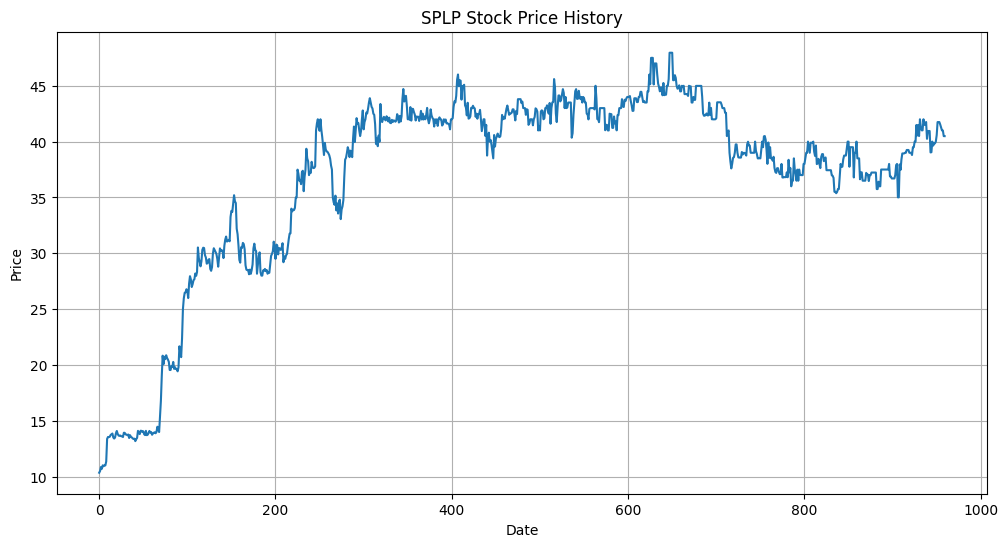

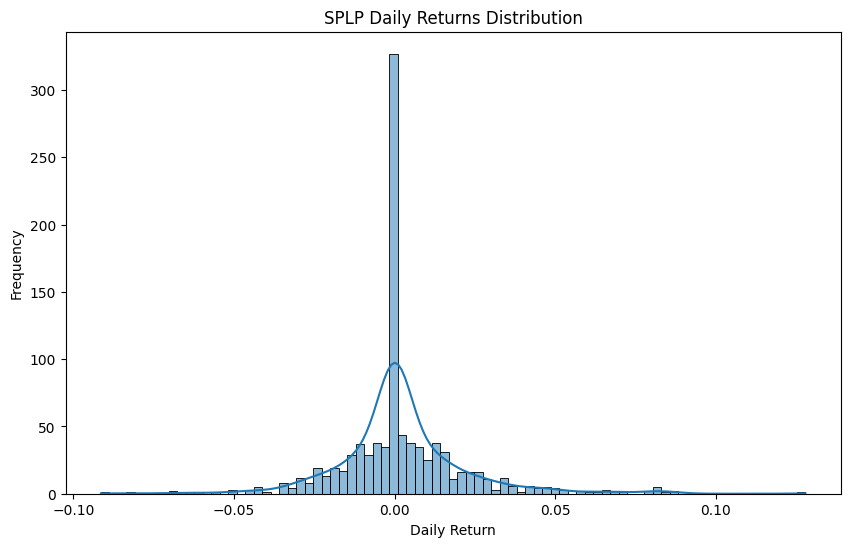


Analysis for TEAM:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

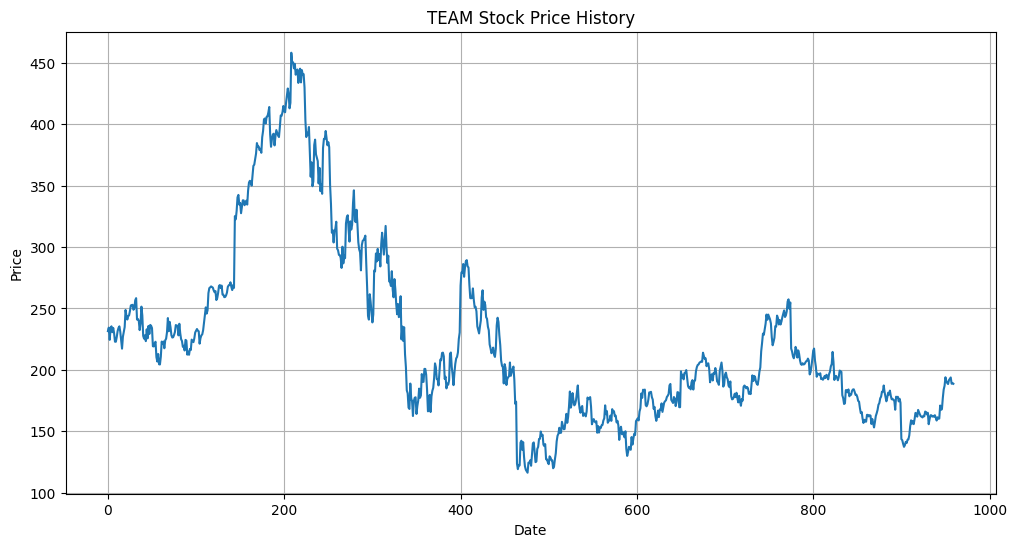

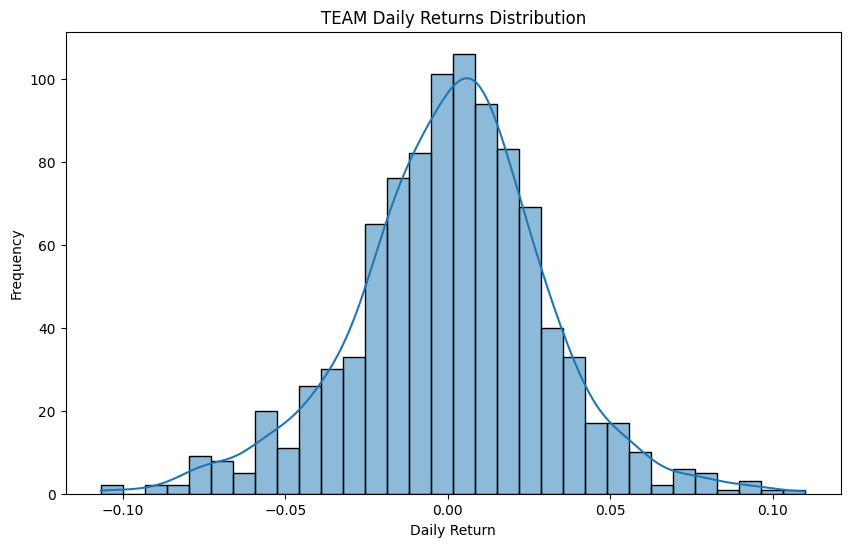


Analysis for BIDU:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

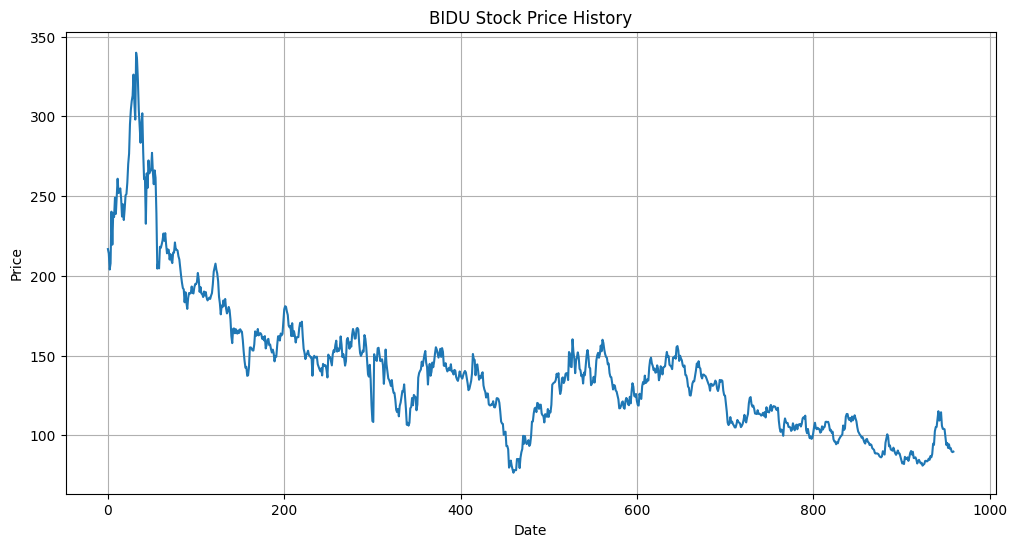

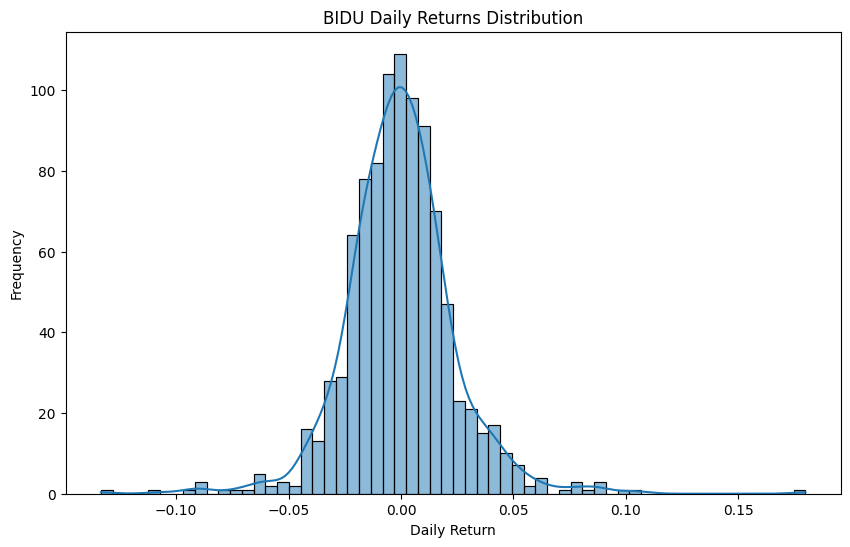


Analysis for ADBE:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

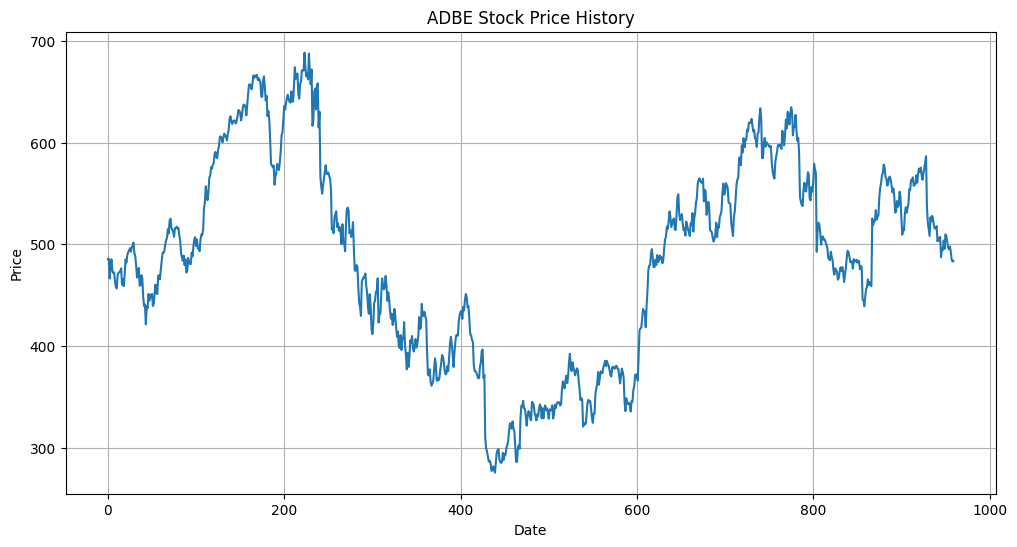

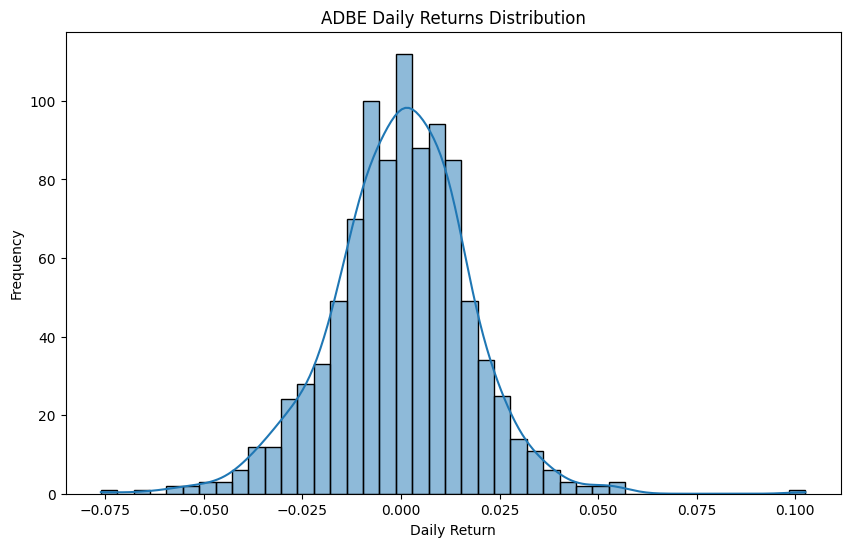


Analysis for MDLZ:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

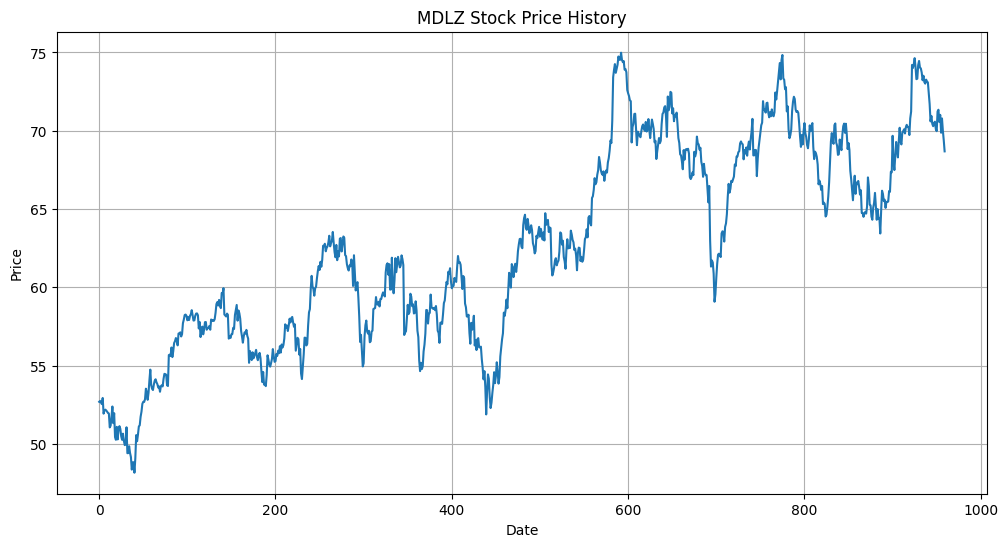

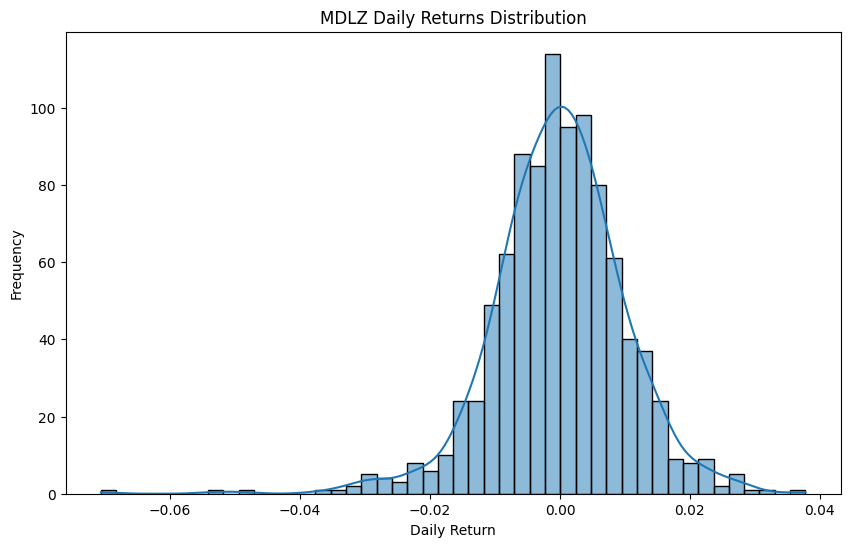


Analysis for AMD:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                     

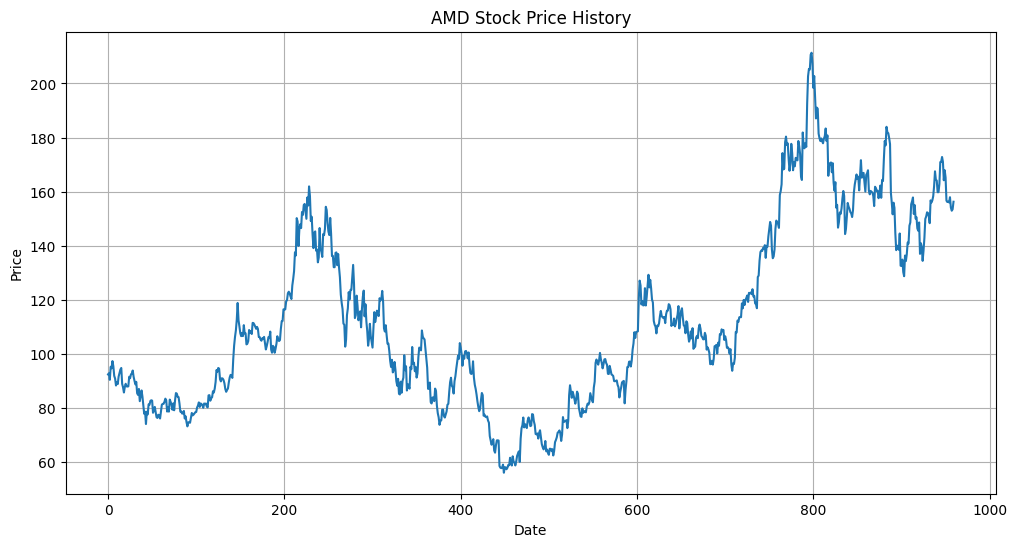

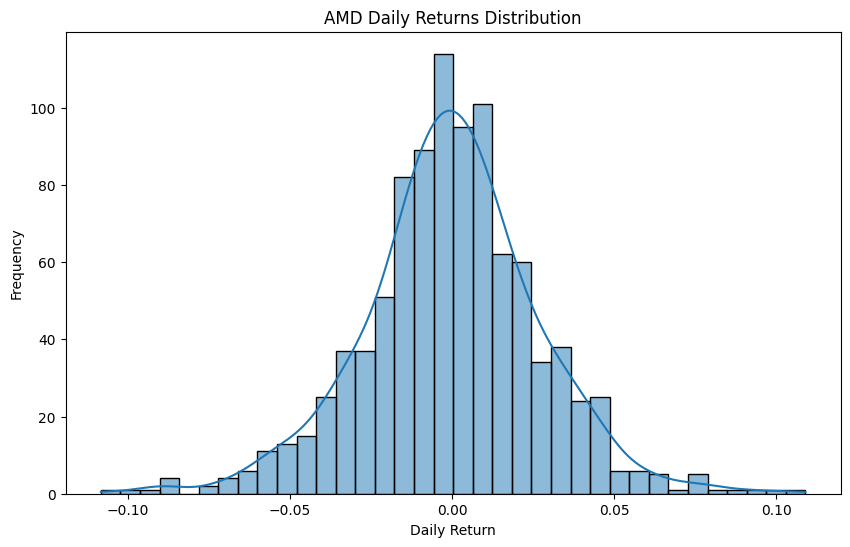


Analysis for VRSN:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

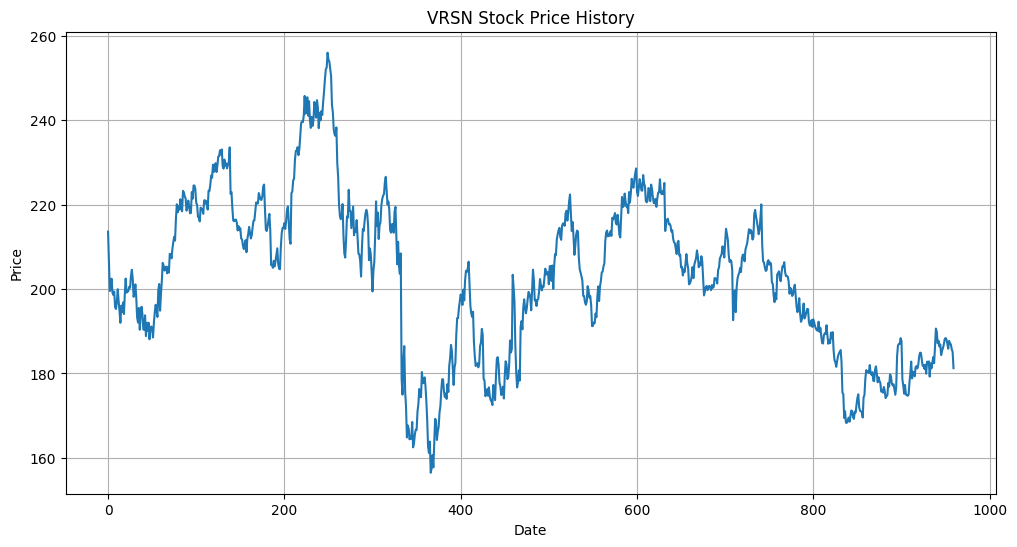

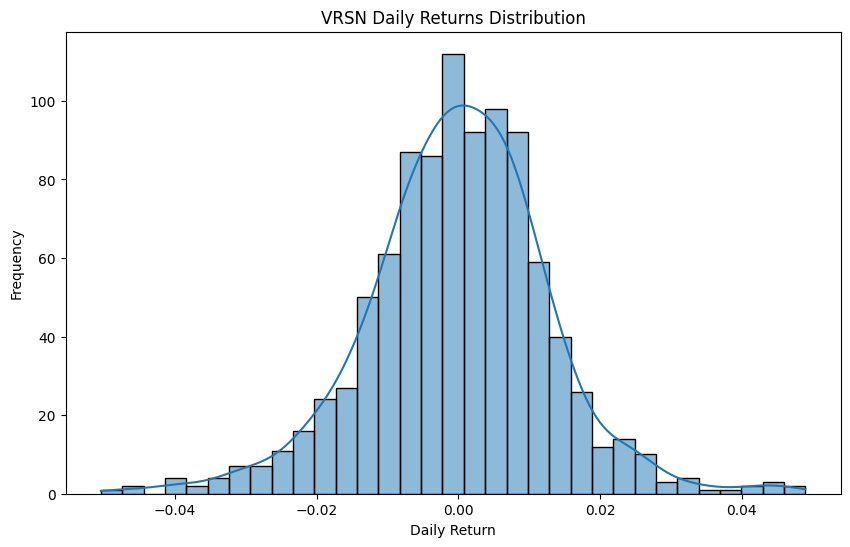


Analysis for PAYX:
--------------------------------------------------

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          960 non-null    datetime64[ns]
 1   Open          960 non-null    float64       
 2   High          960 non-null    float64       
 3   Low           960 non-null    float64       
 4   Close         960 non-null    float64       
 5   Volume        960 non-null    int64         
 6   Dividends     960 non-null    float64       
 7   Stock Splits  960 non-null    float64       
 8   Ticker        960 non-null    object        
 9   Daily_Return  960 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 75.1+ KB
None

Summary Statistics:
                                Date        Open        High         Low  \
count                    

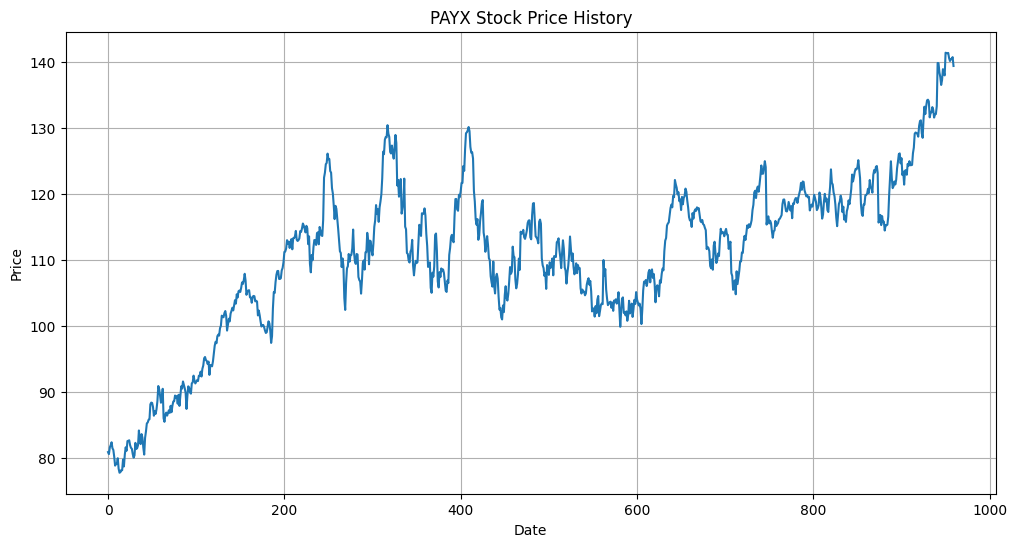

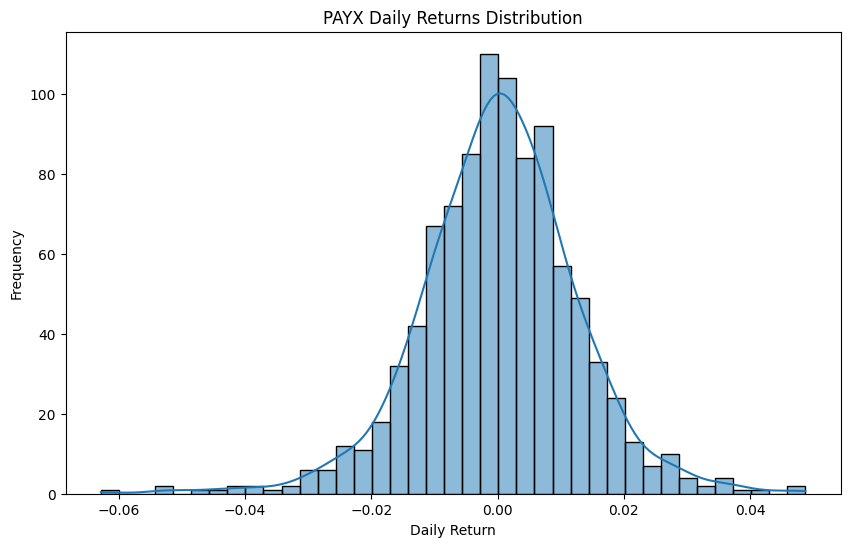

In [98]:
explore_data(all_data)

In [99]:
def plot_stock_data_comparisons(stock_data):
    """
    Plot multiple aspects of stock data for all tickers in the dictionary.
    
    Parameters:
    stock_data (dict): Dictionary with stock tickers as keys and pandas DataFrames as values
    """
    fig, axes = plt.subplots(5, 1, figsize=(14, 20), sharex=True)

    # Plot Open Prices
    for ticker, df in stock_data.items():
        axes[0].plot(df.index, df['Open'], label=ticker)
    axes[0].set_title('Open Prices for All Stocks', fontsize=14)
    axes[0].set_ylabel('Price')
    axes[0].legend(loc='best', fontsize=10)
    axes[0].grid(True)
    
    # Plot Volumes
    for ticker, df in stock_data.items():
        axes[1].plot(df.index, df['Volume'], label=ticker)
    axes[1].set_title('Volumes for All Stocks', fontsize=14)
    axes[1].set_ylabel('Volume')
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid(True)

    # Plot Low-High Range (Confidence Interval)
    for ticker, df in stock_data.items():
        axes[2].fill_between(df.index, df['Low'], df['High'], alpha=0.3, label=ticker)
    axes[2].set_title('Low-High Range for All Stocks', fontsize=14)
    axes[2].set_ylabel('Price Range')
    axes[2].legend(loc='best', fontsize=10)
    axes[2].grid(True)

    # Plot Dividends
    for ticker, df in stock_data.items():
        axes[3].plot(df.index, df['Dividends'], label=ticker)
    axes[3].set_title('Dividends for All Stocks', fontsize=14)
    axes[3].set_ylabel('Dividends')
    axes[3].legend(loc='best', fontsize=10)
    axes[3].grid(True)

    # Plot Daily Returns
    for ticker, df in stock_data.items():
        axes[4].plot(df.index, df['Daily_Return'], label=ticker)
    axes[4].set_title('Daily Returns for All Stocks', fontsize=14)
    axes[4].set_ylabel('Daily Return')
    axes[4].legend(loc='best', fontsize=10)
    axes[4].grid(True)

    # Adjust layout and show plot
    plt.xlabel('Date', fontsize=12)
    plt.tight_layout()
    plt.show()


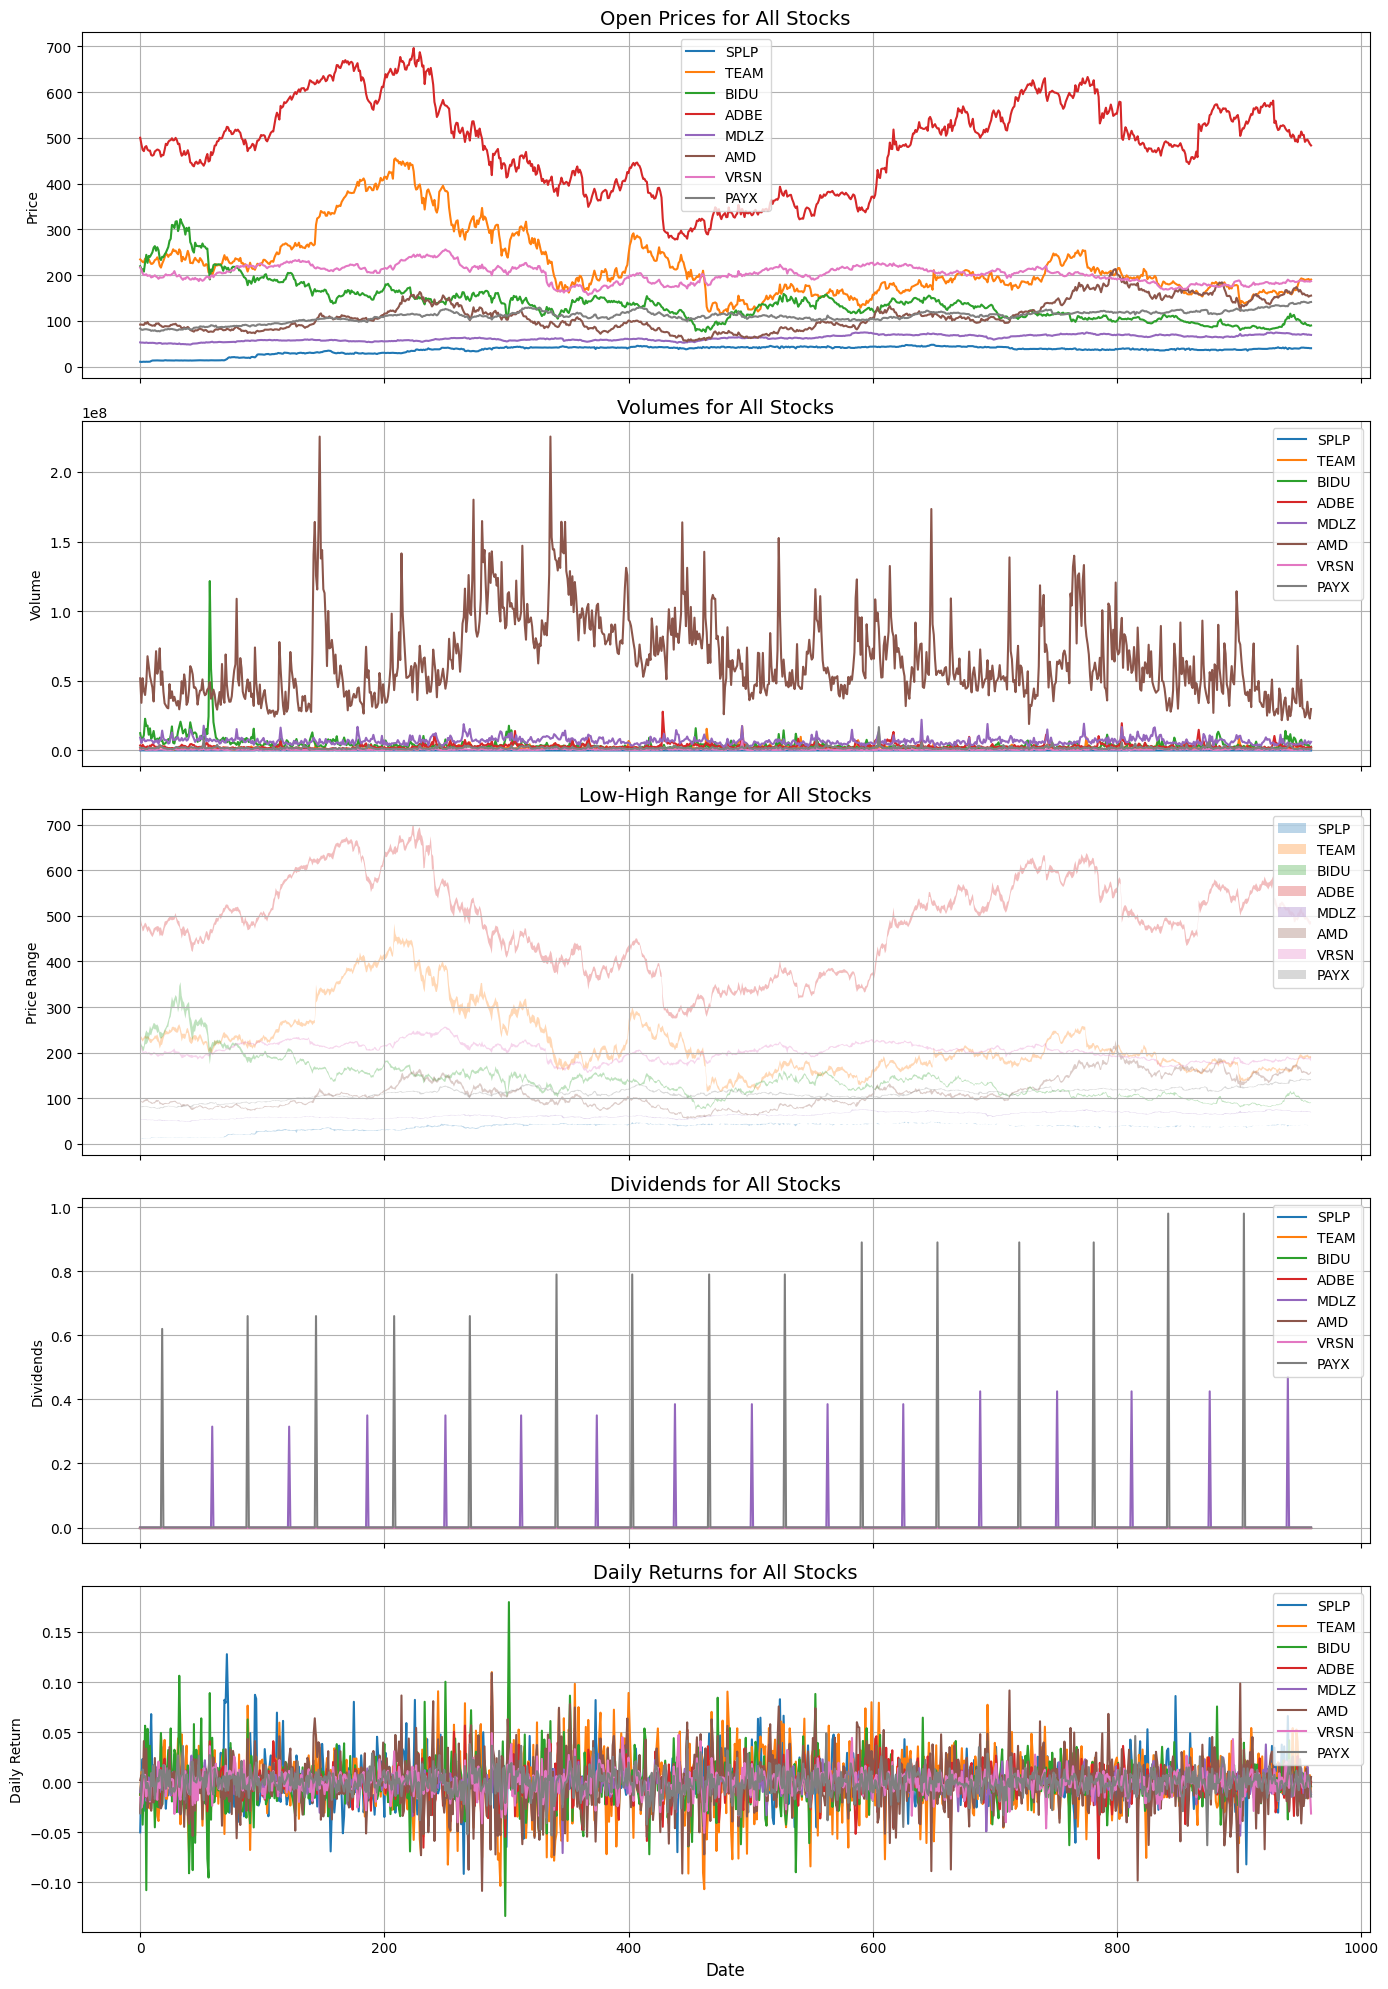

In [100]:
plot_stock_data_comparisons(all_data)

# Efficient Portfolios

In [101]:
combined_returns_cleaned.index = pd.to_datetime(combined_returns_cleaned.index)
risk_free_rate_cleaned.index = pd.to_datetime(risk_free_rate_cleaned.index)
start_date = '2021-01-01'
end_date = '2022-10-24'

# Filter the data by date range using the index
combined_returns_subset = combined_returns_cleaned[(combined_returns_cleaned.index >= start_date) & 
                                  (combined_returns_cleaned.index <= end_date)]
risk_free_subset = risk_free_rate_cleaned[(risk_free_rate_cleaned.index >= start_date) & 
                                  (risk_free_rate_cleaned.index <= end_date)]

In [102]:
risk_free_subset

,1 Mo,Daily_Risk_Free_Rate
2021-01-04,0.09,0.000004
2021-01-05,0.08,0.000003
2021-01-06,0.09,0.000004
2021-01-07,0.09,0.000004
2021-01-08,0.08,0.000003
...,...,...
2022-10-18,3.25,0.000127
2022-10-19,3.31,0.000129
2022-10-20,3.58,0.000140
2022-10-21,3.55,0.000138


In [121]:
expected_returns = combined_returns_subset.mean()
covariance_matrix = combined_returns_subset.cov()
risk_free_rate_one = risk_free_subset['Daily_Risk_Free_Rate'].mean()
print(expected_returns, "\n", covariance_matrix, risk_free_rate_one)

# Extract the  daily risk-free rate from 24.10.2022
#risk_free_rate_one = risk_free_rate_cleaned.loc['2022-10-24', 'Daily_Risk_Free_Rate']
    #??? Is the daily_risk_free rate correct? Also should not I use different risk free rate than the last one? I should work with daily log returns right?


SPLP    0.001482
TEAM    0.000115
BIDU   -0.000693
ADBE   -0.000482
MDLZ   -0.000219
AMD    -0.001226
VRSN   -0.000023
PAYX    0.000454
dtype: float64 
           SPLP      TEAM      BIDU      ADBE      MDLZ       AMD      VRSN  \
SPLP  0.000554  0.000069  0.000075  0.000070  0.000004  0.000089  0.000039   
TEAM  0.000069  0.001010  0.000438  0.000403  0.000050  0.000530  0.000226   
BIDU  0.000075  0.000438  0.000867  0.000239  0.000043  0.000340  0.000119   
ADBE  0.000070  0.000403  0.000239  0.000349  0.000053  0.000330  0.000174   
MDLZ  0.000004  0.000050  0.000043  0.000053  0.000112  0.000042  0.000060   
AMD   0.000089  0.000530  0.000340  0.000330  0.000042  0.000827  0.000194   
VRSN  0.000039  0.000226  0.000119  0.000174  0.000060  0.000194  0.000203   
PAYX  0.000053  0.000168  0.000104  0.000135  0.000068  0.000155  0.000112   

          PAYX  
SPLP  0.000053  
TEAM  0.000168  
BIDU  0.000104  
ADBE  0.000135  
MDLZ  0.000068  
AMD   0.000155  
VRSN  0.000112  
PAYX  0.

In [104]:
def portfolio_stats(weights, expected_returns, covariance_matrix, timeAnnual):
    """
    Calculate portfolio return and portfolio standard deviation.
    """
    # Annualized return
    portfolio_return = np.sum(weights * expected_returns) * timeAnnual 
    # Annualized standard deviation
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights))) * np.sqrt(timeAnnual)
    return portfolio_return, portfolio_stddev

In [105]:
# Simulate random portfolios
num_portfolios = 10000
timeAnnual = 252  # Trading year
num_assets = len(expected_returns)
results = np.zeros((3, num_portfolios))  # Rows: return, risk (std dev), Sharpe ratio

In [106]:
def get_min_variance_portfolio(expected_returns, covariance_matrix, num_assets):
    """
    Calculate the minimum variance portfolio, considering risk-free rate.
    """

    constraints = ({"type": "eq", "fun": lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    result = minimize(
        fun=lambda w: portfolio_stats(w, expected_returns, covariance_matrix, timeAnnual)[1],
        x0=num_assets * [1.0 / num_assets],
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    
    return result.x

In [160]:
def minimize_volatility(target_return, expected_returns, covariance_matrix, num_assets):
    """
    Minimize portfolio volatility for a given target return.
    """    
    constraints = (
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},  # Weights sum to 1
        {"type": "eq", "fun": lambda w: np.sum(w * expected_returns) * timeAnnual - target_return}  # Target return
    )
    bounds = tuple((0, 1) for _ in range(num_assets)) #(0,1) w/o short, (-1,1) w/ short
    
    result = minimize(
        fun=lambda w: portfolio_stats(w, expected_returns, covariance_matrix, timeAnnual)[1],
        x0=num_assets * [1.0 / num_assets],
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    return result.x

In [161]:
# Simulate random portfolios
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets))
    weights /= np.sum(weights)
    portfolio_return, portfolio_stddev = portfolio_stats(weights, expected_returns, covariance_matrix, timeAnnual)
    results[0, i] = portfolio_return
    results[1, i] = portfolio_stddev
    results[2, i] = (portfolio_return - risk_free_rate_one) / portfolio_stddev
    #print(results)

In [162]:
# Find the maximum Sharpe ratio portfolio
max_sharpe_idx = np.argmax(results[2,:])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_stddev = results[1, max_sharpe_idx]


In [163]:
# Get minimum variance portfolio
min_var_weights = get_min_variance_portfolio(expected_returns, covariance_matrix, num_assets)
min_var_return, min_var_risk = portfolio_stats(min_var_weights, expected_returns, covariance_matrix, timeAnnual)


In [164]:
# Generate efficient frontier points
target_returns = np.linspace(expected_returns.min()*252, expected_returns.max()*252, 100) #expected_returns.max()*252*2.5 for short sell
frontier_returns = []
frontier_risks = []

for target_return in target_returns:
    weights = minimize_volatility(target_return, expected_returns, covariance_matrix, num_assets)
    ret, risk = portfolio_stats(weights, expected_returns, covariance_matrix, timeAnnual)
    frontier_returns.append(ret)
    frontier_risks.append(risk)

# Calculate Capital Market Line
max_sharpe_index = np.argmax([ (ret - risk_free_rate_one*timeAnnual) / risk for ret, risk in zip(frontier_returns, frontier_risks)])

tangency_return = frontier_returns[max_sharpe_index]
tangency_risk = frontier_risks[max_sharpe_index]

# Slope of the Capital Market Line (CML)
slope_cml = (tangency_return - risk_free_rate_one*timeAnnual) / tangency_risk

# Calculate x_cml and y_cml (Capital Market Line)
x_cml = np.linspace(0, max(frontier_risks), 100)
y_cml = risk_free_rate_one*timeAnnual + slope_cml * x_cml




C:\Users\vojta\AppData\Local\Temp\ipykernel_17748\1359005244.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(risks[i], returns[i],


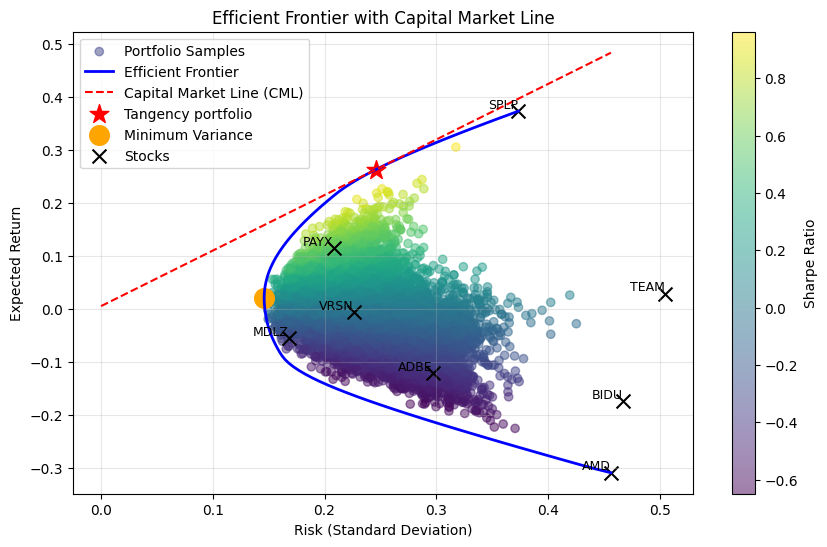

In [165]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot random portfolios
scatter = plt.scatter(results[1, :], results[0, :], 
                     c=results[2, :], 
                     cmap='viridis', 
                     alpha=0.5, 
                     label='Portfolio Samples')

# Plot efficient frontier
plt.plot(frontier_risks, frontier_returns, 
        color='blue', 
        linewidth=2, 
        label='Efficient Frontier')

# Plot CML
plt.plot(x_cml, y_cml, 
color='red', 
        linestyle='--', 
        label='Capital Market Line (CML)')

# Plot maximum tangency portfolio
plt.scatter(tangency_risk, tangency_return, 
          color='red', 
          marker='*', 
          s=200, 
          label='Tangency portfolio')

# Plot minimum variance point
plt.scatter(min_var_risk, min_var_return, 
          color='orange', 
          marker='o', 
          s=200, 
          label='Minimum Variance')

# Plot individual assets (stocks)
tickers = list(stock_files.keys())
# Calculate risks and returns for all stocks
risks = np.sqrt(np.diag(covariance_matrix)) * np.sqrt(timeAnnual)  # Standard deviation
returns = expected_returns * timeAnnual  # Annualized returns

# Plot all stocks in one scatter call
plt.scatter(risks, returns, 
            color='black', 
            marker='x', 
            s=100, 
            label='Stocks')

# Add tickers as text annotations
for i, ticker in enumerate(tickers):
    plt.text(risks[i], returns[i], 
             ticker, 
             fontsize=9, 
             ha='right', 
             va='bottom')

plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Capital Market Line')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()



Text(0, 0.5, 'Expected Return')

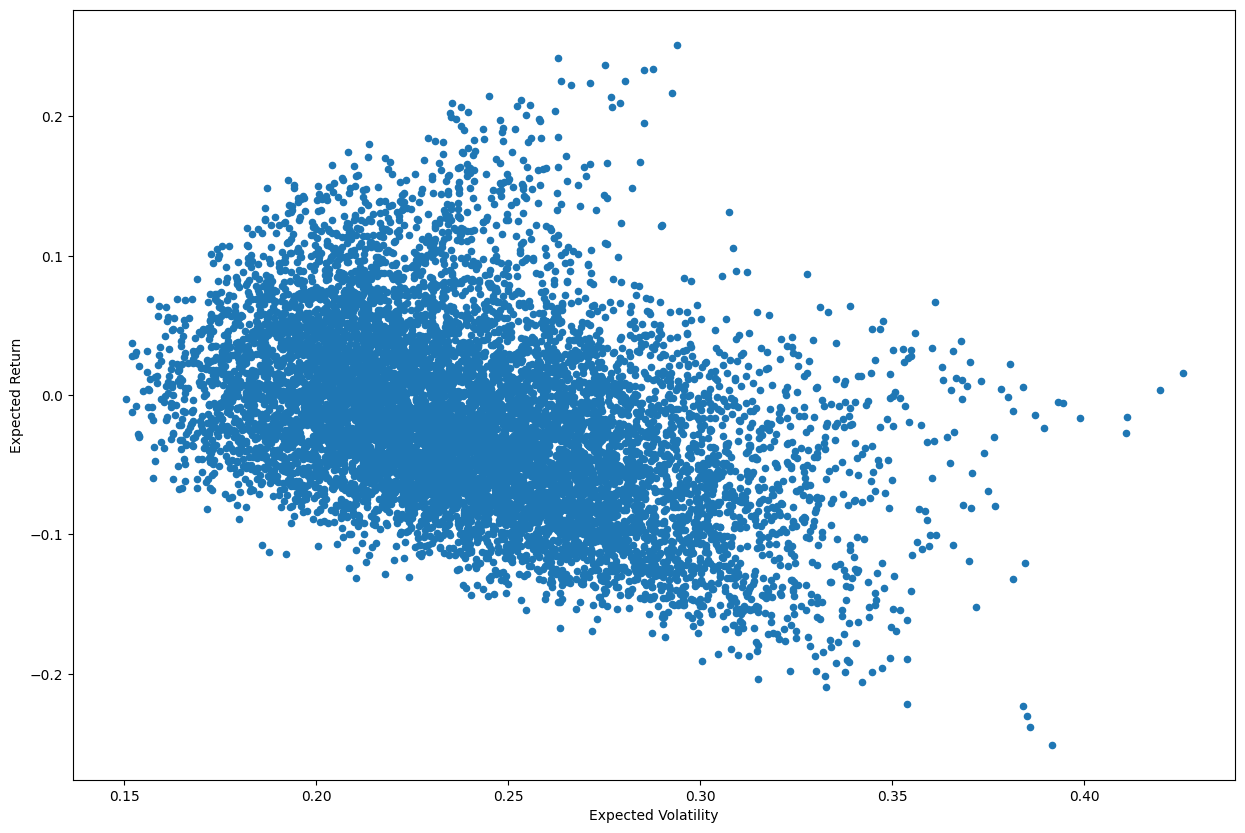

In [113]:
portfolios = pd.DataFrame({'Return': results[0, ], 'Volatility':results[1, ]})
portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(15,10));
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')

C:\Users\vojta\AppData\Local\Temp\ipykernel_17748\3071231635.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(f"Stock {i+1}", (beta[i], expected_returns[i]))


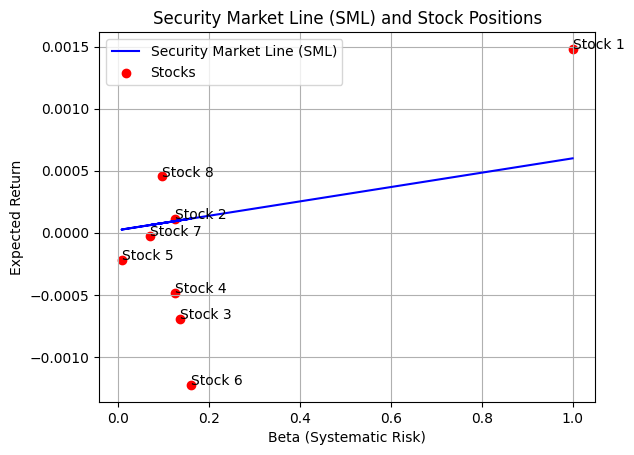

In [114]:
# Assume 'market_return' is the market's return (you can use a relevant benchmark like the S&P 500)
beta = covariance_matrix.iloc[:, 0] / covariance_matrix.iloc[0, 0]  # Simplified calculation using first stock as market proxy
expected_market_return = 0.0006  # Assumed daily expected market return (about 15% annually) ???
sml = risk_free_rate_one + beta * (expected_market_return - risk_free_rate_one)  # SML formula

# Plot the SML
plt.plot(beta, sml, label="Security Market Line (SML)", color='blue')

# Plot individual stocks based on their expected returns and betas
plt.scatter(beta, expected_returns, color='red', label="Stocks")
for i, txt in enumerate(expected_returns):
    plt.annotate(f"Stock {i+1}", (beta[i], expected_returns[i]))

# Labels and title
plt.title("Security Market Line (SML) and Stock Positions")
plt.xlabel("Beta (Systematic Risk)")
plt.ylabel("Expected Return")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [115]:
#Youtube video
#################################################################################
def portfolioPerformance(weights, meanReturns, covMatrix, Time): #Time in days I guess
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)

returns['portfolio'] = returns.dot(weights)
##############################################################################

def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

# 100 days
Time = 100

hVaR = -historicalVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
hCVaR = -historicalCVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)

InitialInvestment = 10000
print('Expected Portfolio Return:      ', round(InitialInvestment*pRet,2))
print('Value at Risk 95th CI    :      ', round(InitialInvestment*hVaR,2))
print('Conditional VaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))

AttributeError: 'Series' object has no attribute 'columns'

# The Markowitz Model

We have choosen strategy of min risk, min expected returns = 6 % p.a, the historical/empirical data was used.

#TODO: Try different estimation methods

In [ ]:
def calculate_efficient_portfolio_with_rf(combined_returns, min_return, risk_free_rate):
    # Calculate excess returns and covariance matrix
    excess_returns = combined_returns.mean() - risk_free_rate
    covariance_matrix = combined_returns.cov()
    num_risky_assets = len(excess_returns)
    
    def objective(w):
        risky_weights = w[:-1]
        return 0.5 * np.dot(risky_weights.T, np.dot(covariance_matrix, risky_weights))
    
    def return_constraint(w):
        risky_weights = w[:-1]
        rf_weight = w[-1]
        portfolio_excess_return = np.dot(risky_weights, excess_returns)
        return portfolio_excess_return + risk_free_rate - min_return
    
    def weight_sum_constraint(w):
        return np.sum(w) - 1
    
    constraints = [
        {'type': 'eq', 'fun': weight_sum_constraint},
        {'type': 'ineq', 'fun': return_constraint}
    ]
    
    initial_weights = np.ones(num_risky_assets + 1) / (num_risky_assets + 1)
    bounds = [(0, 1) for _ in range(num_risky_assets + 1)]
    
    result = minimize(objective, initial_weights,
                     constraints=constraints,
                     bounds=bounds,
                     method='SLSQP')
    
    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")
    
    weights = result.x
    risky_weights = weights[:-1]
    rf_weight = weights[-1]
    
    portfolio_risk = np.sqrt(np.dot(risky_weights.T, np.dot(covariance_matrix, risky_weights)))
    portfolio_return = np.dot(risky_weights, combined_returns.mean()) + rf_weight * risk_free_rate
    
    weight_dict = dict(zip(combined_returns.columns, risky_weights))
    weight_dict['risk_free'] = rf_weight
    
    return {
        'weights': weight_dict,
        'portfolio_return': portfolio_return,
        'portfolio_risk': portfolio_risk,
        'risk_free_weight': rf_weight
    }

In [205]:
def calculate_efficient_portfolio_with_rf(min_return, expected_returns, covariance_matrix, num_risky_assets, risk_free_rate):
    # Calculate excess returns and covariance matrix
    excess_returns = expected_returns - risk_free_rate
    
    def objective(w):
        return 0.5 * np.dot(w.T, np.dot(covariance_matrix, w))*timeAnnual
    
    def return_constraint(w):
        portfolio_excess_return = np.dot(w, excess_returns)
        return portfolio_excess_return + risk_free_rate - min_return
    
    constraints = [
        {'type': 'ineq', 'fun': return_constraint}
    ]
    
    initial_weights = np.zeros(num_risky_assets) / (num_risky_assets)
    bounds = [(0, 1) for _ in range(num_risky_assets)]
    
    result = minimize(
        fun=lambda w: objective(w),
        x0=num_risky_assets * [1.0 / (num_risky_assets+1)],
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    
    if not result.success:
        raise ValueError(f"Optimization failed: {result.message}")
    
    weights = result.x
    risky_weights = weights
    rf_weight = 1-np.sum(risky_weights)
    
    portfolio_risk = np.sqrt(np.dot(risky_weights.T, np.dot(covariance_matrix, risky_weights)))
    portfolio_return = (np.dot(risky_weights, expected_returns) + rf_weight * risk_free_rate)
    
    # weight_dict = dict(zip(expected_returns.columns, risky_weights))
    # weight_dict['risk_free'] = rf_weight
    
    return {
        'weights': risky_weights,
        'portfolio_return': portfolio_return,
        'portfolio_risk': portfolio_risk,
        'risk_free_weight': rf_weight
    }

In [208]:
expected_returns = combined_returns_cleaned.mean()
covariance_matrix = combined_returns_cleaned.cov()
risk_free_rate_all = risk_free_rate_cleaned['Daily_Risk_Free_Rate'].mean()

In [209]:
# Example usage:
# Replace `stock_data` with your data (a dictionary of DataFrames with 'Close' prices for each stock)
# Set a minimum daily return (e.g., 0.00023 for ~6% annual return)
min_return = 0.00023
portfolioMark = calculate_efficient_portfolio_with_rf(min_return, expected_returns, covariance_matrix, num_assets, risk_free_rate_all)

print("Portfolio weights:", portfolioMark['weights'])
print("Expected return:", portfolioMark['portfolio_return'])
print("Portfolio risk:", portfolioMark['portfolio_risk'])
print("Risk-free asset weight:", portfolioMark['risk_free_weight'])
print(sum(portfolioMark['weights'])+portfolioMark['risk_free_weight'])

Portfolio weights: [5.32252973e-02 7.96790073e-03 3.10344593e-19 0.00000000e+00
 0.00000000e+00 1.70271976e-19 2.31452357e-21 0.00000000e+00]
Expected return: 0.00022999999999483956
Portfolio risk: 0.0011121446276610354
Risk-free asset weight: 0.9388068020097051
1.0


C:\Users\vojta\AppData\Local\Temp\ipykernel_17748\2068781636.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_returns[i]*timeAnnual,


AttributeError: 'numpy.ndarray' object has no attribute 'items'

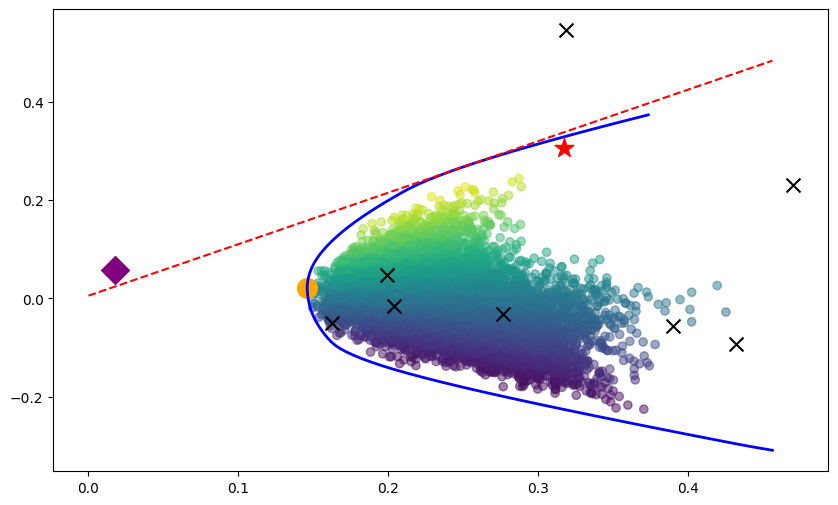

In [210]:
# Your existing plot code with Markowitz additions
plt.figure(figsize=(10, 6))

# Plot random portfolios (your existing code)
scatter = plt.scatter(results[1, :], results[0, :], 
                     c=results[2, :], 
                     cmap='viridis', 
                     alpha=0.5, 
                     label='Portfolio Samples')

# Plot efficient frontier (your existing code)
plt.plot(frontier_risks, frontier_returns, 
        color='blue', 
        linewidth=2, 
        label='Efficient Frontier')

# Get Markowitz results and add to plot
markowitz_risk = portfolioMark['portfolio_risk'] * np.sqrt(timeAnnual)
markowitz_return = portfolioMark['portfolio_return'] * timeAnnual

# Plot Markowitz optimal portfolio
plt.scatter(markowitz_risk, markowitz_return,
           color='purple',
           marker='D',
           s=200,
           label='Markowitz Optimal')

# Plot CML using Markowitz portfolio (your existing code, updated)
plt.plot(x_cml, y_cml, 
         color='red', 
         linestyle='--', 
         label='Capital Market Line (CML)')

# Your existing code continues...
# Plot maximum Sharpe ratio point
plt.scatter(max_sharpe_stddev, max_sharpe_return, 
          color='red', 
          marker='*', 
          s=200, 
          label='Maximum Sharpe ratio')

# Plot minimum variance point
plt.scatter(min_var_risk, min_var_return, 
          color='orange', 
          marker='o', 
          s=200, 
          label='Minimum Variance')

# Plot individual assets (stocks)
for i in range(len(expected_returns)):
    plt.scatter(np.sqrt(covariance_matrix.iloc[i, i])* np.sqrt(timeAnnual),
                expected_returns[i]*timeAnnual,
                color='black', 
                marker='x', 
                s=100, 
                label=f'Stock' if i == 0 else "")

# Add Markowitz weights as text
weights_text = "Markowitz Weights:\n"
for asset, weight in portfolioMark['weights'].items():
    weights_text += f"{asset}: {weight:.3f}\n"
plt.text(0.02, 0.02, weights_text,
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         fontsize=8)

plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Capital Market Line')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

In [66]:
def calculate_minimum_risk_portfolio(combined_returns, min_return, risk_free_rate):
    """
    Minimize portfolio risk subject to a minimum expected return, considering the risk-free rate.
    
    Parameters:
    combined_returns (pd.DataFrame): DataFrame with asset returns (stocks as columns).
    min_return (float): Minimum expected return (daily).
    risk_free_rate (float): The risk-free rate (daily), assumed constant over time.

    Returns:
    dict: Portfolio weights and resulting risk/return.
    """
    # Init characteristics
    expected_returns = combined_returns.mean() - risk_free_rate  # Adjust expected returns for the risk-free rate
    covariance_matrix = combined_returns.cov()
    num_assets = len(expected_returns)
    
    # Initial guess for weights
    initial_weights = np.ones(num_assets) / num_assets
    
    # Constraints: Weights sum to 1, portfolio return >= min_return
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Sum of weights = 1
        {'type': 'ineq', 'fun': lambda w: np.dot(w, expected_returns) - min_return}  # Portfolio return >= min_return
    ]
    
    # Bounds for weights (0 to 1)
    bounds = [(0, 1) for _ in range(num_assets)]
    
    # Objective function: Portfolio risk (standard deviation)
    def portfolio_risk(w):
        return np.sqrt(np.dot(w.T, np.dot(covariance_matrix, w)))
    
    # Minimize portfolio risk
    resultMark = minimize(portfolio_risk, initial_weights, constraints=constraints, bounds=bounds)
    
    # Check if optimization was successful
    if not resultMark.success:
        raise ValueError("Optimization failed:", resultMark.message)
    
    # Portfolio weights, risk, and return
    weights = resultMark.x
    portfolio_return = np.dot(weights, expected_returns) + risk_free_rate  # Adjust portfolio return back to actual return
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    
    return {
        'weights': dict(zip(combined_returns.columns, weights)),
        'portfolio_return': portfolio_return,
        'portfolio_risk': portfolio_risk
    }


In [67]:
# Example usage:
# Replace `stock_data` with your data (a dictionary of DataFrames with 'Close' prices for each stock)
# Set a minimum daily return (e.g., 0.00023 for ~6% annual return)
min_return = 0.00023
resultMark = calculate_minimum_risk_portfolio(combined_returns_subset, min_return, risk_free_rate_one)

In [68]:
# Print optimal portfolio weights and performance
print("Optimal Portfolio Weights:", resultMark['weights'])
print(f"Portfolio Expected Return: {resultMark['portfolio_return']}")
print(f"Portfolio Risk (Std Dev): {resultMark['portfolio_risk']}")
print(sum(resultMark['weights'].values()))

Optimal Portfolio Weights: {'SPLP': 0.17814225983654894, 'TEAM': 0.0, 'BIDU': 0.0, 'ADBE': 4.7704895589362195e-18, 'MDLZ': 0.5004945974110149, 'AMD': 8.673617379884035e-19, 'VRSN': 0.10179116664105513, 'PAYX': 0.21957197611138118}
Portfolio Expected Return: 0.00025157817477815714
Portfolio Risk (Std Dev): 0.009396627381653255
1.0000000000000002


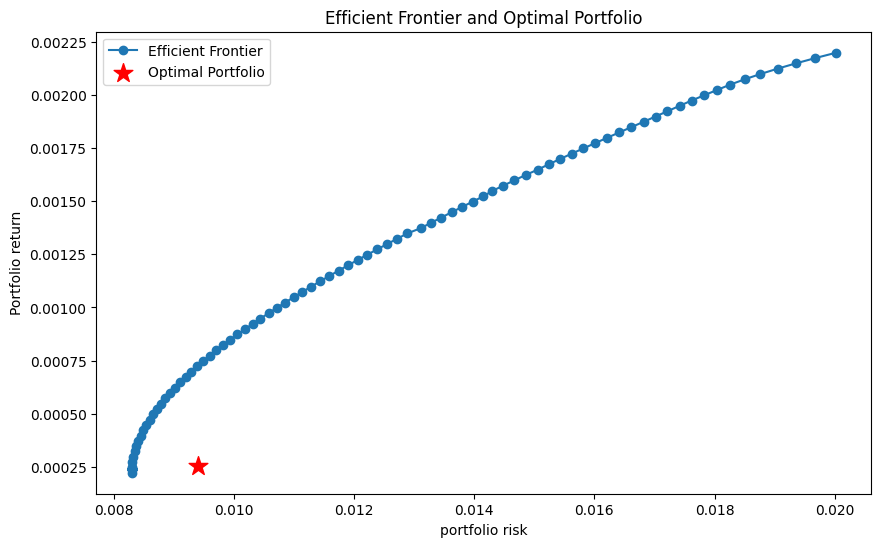

In [69]:
# Visualization: Efficient Frontier
market_return = resultMark['portfolio_return']
market_risk = resultMark['portfolio_risk']
num_portfolios = 100
results = np.zeros((3, num_portfolios))
# Get max and min expected returns to ensure feasible minimum return
min_expected_return = combined_returns.mean().min()
max_expected_return = combined_returns.mean().max()
for i in range(num_portfolios):
    # Vary the expected return for each portfolio
    min_return = min_expected_return + (i / num_portfolios) * (max_expected_return - min_expected_return)
    
    try:
        portfolio = calculate_minimum_risk_portfolio(combined_returns, min_return, risk_free_rate_one)
        results[0, i] = portfolio['portfolio_risk']
        results[1, i] = portfolio['portfolio_return']
    except ValueError as e:
        # Handle cases where optimization fails
        print(f"Optimization failed for target return {min_return:.4f}. Skipping.")
        results[0, i] = np.nan
        results[1, i] = np.nan


# Plot CML (opacko from above, still not working)
# ??? How to choose market risk and market returns
cml_x = np.linspace(0, market_risk * 1.5, 100)
cml_y = risk_free_rate_one + (cml_x / market_risk) * (market_return - risk_free_rate_one)
# Plot efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(results[0, :], results[1, :], marker='o', label='Efficient Frontier')
#plt.plot(cml_x, cml_y, color='green', label='Capital Market Line (CML)') (same naprd results)
plt.scatter(resultMark['portfolio_risk'], resultMark['portfolio_return'], color='red', marker='*', s=200, label='Optimal Portfolio')
plt.title('Efficient Frontier and Optimal Portfolio')
plt.xlabel('portfolio risk')
plt.ylabel('Portfolio return')
plt.legend(loc='best')
plt.show()

# Out-Of-Sample Investing

In [70]:
# Function to calculate the fixed tangency portfolio (Sharpe-maximizing portfolio)
def calculate_tangency_portfolio(returns, risk_free_rate_cleaned):
    # Get expected returns and covariance matrix
    expected_returns = returns.mean()
    covariance_matrix = returns.cov()
    
    # Risk-free rate (example, you can adjust based on your context)
    risk_free_rate = risk_free_rate_cleaned.mean()
    
    # Calculate excess returns (subtract risk-free rate)
    excess_returns = expected_returns - risk_free_rate
    
    # Ensure the excess returns vector has the same shape as the covariance matrix
    excess_returns = excess_returns[:covariance_matrix.shape[0]]  # Trim excess returns to match the covariance matrix shape
    
    # Calculate weights using the inverse of the covariance matrix
    weights = np.linalg.inv(covariance_matrix).dot(excess_returns)
    
    # Normalize weights to sum to 1
    weights = weights / np.sum(weights)
    
    # Calculate portfolio return and risk
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    
    return {'weights': weights, 'portfolio_return': portfolio_return, 'portfolio_risk': portfolio_risk}
    
    return {'weights': weights, 'portfolio_return': portfolio_return, 'portfolio_risk': portfolio_risk}

# Example of daily investment strategy
def simulate_strategy(stock_data, min_return, start_date, end_date, risk_free_rate_cleaned):
    # Filter data for the given date range
    stock_data = stock_data.loc[start_date:end_date]
    
    # Store results
    portfolio_values_optimal = []
    portfolio_values_naive = []
    portfolio_values_tangency = []
    
    # Initialize the portfolio value (starting with $1)
    initial_value = 1
    portfolio_value_optimal = initial_value
    portfolio_value_naive = initial_value
    portfolio_value_tangency = initial_value
    
    # Simulate the investment over time
    for i in range(1, len(stock_data)):
        # Calculate returns up to the current date
        daily_returns = stock_data.iloc[:i]
        
        # Calculate optimal portfolio based on historical data
        optimal_portfolio = calculate_minimum_risk_portfolio(daily_returns, min_return)
        optimal_weights = optimal_portfolio['weights']
        
        # Naive portfolio (equal weights)
        num_assets = len(daily_returns.columns)
        naive_weights = np.ones(num_assets) / num_assets
        
        # Fixed tangency portfolio (based on entire data)
        tangency_portfolio = calculate_tangency_portfolio(daily_returns,risk_free_rate_cleaned)
        tangency_weights = tangency_portfolio['weights']
        
        # Calculate daily returns for each strategy
        daily_returns_optimal = np.dot(daily_returns.iloc[i], optimal_weights)
        daily_returns_naive = np.dot(daily_returns.iloc[i], naive_weights)
        daily_returns_tangency = np.dot(daily_returns.iloc[i], tangency_weights)
        
        # Update portfolio values
        portfolio_value_optimal *= (1 + daily_returns_optimal)
        portfolio_value_naive *= (1 + daily_returns_naive)
        portfolio_value_tangency *= (1 + daily_returns_tangency)
        
        # Store portfolio values
        portfolio_values_optimal.append(portfolio_value_optimal)
        portfolio_values_naive.append(portfolio_value_naive)
        portfolio_values_tangency.append(portfolio_value_tangency)
    
    # Convert results to a DataFrame
    results = pd.DataFrame({
        'Date': stock_data.index[1:],
        'Optimal Portfolio Value': portfolio_values_optimal,
        'Naive Portfolio Value': portfolio_values_naive,
        'Tangency Portfolio Value': portfolio_values_tangency
    })
    
    return results


In [71]:
# Simulate the strategy for a given date range
start_date = '2022-10-25'
end_date = '2024-10-24'
min_return = 0.00023  # Example minimum daily return (~6% annual return)

# Simulate the strategy and get the results
portfolio_results = simulate_strategy(combined_returns_cleaned, min_return, start_date, end_date, risk_free_rate_cleaned)

# Plot the portfolio values over time
plt.figure(figsize=(10, 6))
plt.plot(portfolio_results['Date'], portfolio_results['Optimal Portfolio Value'], label='Optimal Strategy')
plt.plot(portfolio_results['Date'], portfolio_results['Naive Portfolio Value'], label='Naive Strategy')
plt.plot(portfolio_results['Date'], portfolio_results['Tangency Portfolio Value'], label='Tangency Portfolio')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Performance Comparison')
plt.legend()
plt.show()

# Print the final portfolio values and compare them
final_optimal_value = portfolio_results['Optimal Portfolio Value'].iloc[-1]
final_naive_value = portfolio_results['Naive Portfolio Value'].iloc[-1]
final_tangency_value = portfolio_results['Tangency Portfolio Value'].iloc[-1]

print(f"Final Optimal Portfolio Value: {final_optimal_value}")
print(f"Final Naive Portfolio Value: {final_naive_value}")
print(f"Final Tangency Portfolio Value: {final_tangency_value}")

TypeError: calculate_minimum_risk_portfolio() missing 1 required positional argument: 'risk_free_rate'